In [1]:
# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import glob
import os
import fnmatch

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation

In [2]:
# load files paths
data_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\\'
output_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\casr_data\\'
shapefile_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\Elevation\Bow_elevation_combined.shp'

# 1. open all swe data files and combine them into a single xarray dataset spatially and temporally

In [3]:
swe = xr.open_dataset(data_path + 'CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat421-455_2000-2003.nc')
dataframe = swe.to_dataframe().reset_index()
display(dataframe)


,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_P_SWE_LAND
0,1999-12-31 13:00:00,-6.30,-16.497223,242.215729,48.815422,1,NaN
1,1999-12-31 13:00:00,-6.30,-16.407211,242.342209,48.848152,1,NaN
2,1999-12-31 13:00:00,-6.30,-16.317215,242.468872,48.880726,1,NaN
3,1999-12-31 13:00:00,-6.30,-16.227219,242.595703,48.913143,1,NaN
4,1999-12-31 13:00:00,-6.30,-16.137222,242.722687,48.945408,1,NaN
...,...,...,...,...,...,...,...
42953395,2003-12-31 12:00:00,-3.24,-13.797226,244.502960,52.624481,1,3.125
42953396,2003-12-31 12:00:00,-3.24,-13.707214,244.642578,52.654419,1,7.125
42953397,2003-12-31 12:00:00,-3.24,-13.617218,244.782394,52.684174,1,6.375
42953398,2003-12-31 12:00:00,-3.24,-13.527222,244.922394,52.713757,1,7.750


In [4]:
# Step 1: List all SWE files using the correct data_path variable
file_list = sorted(glob.glob(f"{data_path}CaSR_v3.1_P_SWE_LAND_*.nc"))

if not file_list:
    raise FileNotFoundError(f"No files found with pattern {data_path}CaSR_v3.1_P_SWE_LAND_*.nc")

# Step 2: Open and combine them using xarray
ds_combined_swe = xr.open_mfdataset(
    file_list,
    combine='by_coords',  # will automatically align by time and coordinates
    parallel=True,        # if using Dask or want faster loading
    engine='netcdf4'      # or 'h5netcdf' if you're using that backend
)

# Optional: Check dataset structure
print(ds_combined_swe)




<xarray.Dataset> Size: 15GB
Dimensions:               (rlon: 70, rlat: 70, time: 385704)
Coordinates:
  * time                  (time) datetime64[ns] 3MB 1979-12-31T13:00:00 ... 2...
    lon                   (rlat, rlon) float32 20kB dask.array<chunksize=(35, 35), meta=np.ndarray>
    lat                   (rlat, rlon) float32 20kB dask.array<chunksize=(35, 35), meta=np.ndarray>
  * rlon                  (rlon) float64 560B -16.5 -16.41 ... -10.38 -10.29
  * rlat                  (rlat) float64 560B -9.45 -9.36 -9.27 ... -3.33 -3.24
Data variables:
    rotated_pole          (rlon, rlat, time) int32 8GB 1 1 1 1 1 1 ... 1 1 1 1 1
    CaSR_v3.1_P_SWE_LAND  (time, rlat, rlon) float32 8GB dask.array<chunksize=(1, 35, 35), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    source:       https://hpfx.collab.science.gc.ca/~scar700/rcas-casr/
    institution:  Environment and Climate Change Canada / Environnement et Ch...
    title:        Canadian Surface Reanalysis (CaSR) / Réanalyse 

In [51]:
# Select a small subset (e.g., first time step) to avoid MemoryError
subset = ds_combined_swe.isel(time=0)
swe_df = subset.to_dataframe().reset_index()
display(swe_df)


,rlon,rlat,rotated_pole,CaSR_v3.1_P_SWE_LAND,time,lon,lat
0,-16.497223,-9.450001,1,NaN,1979-12-31 13:00:00,243.874023,45.872429
1,-16.497223,-9.360001,1,NaN,1979-12-31 13:00:00,243.829147,45.956844
2,-16.497223,-9.270000,1,NaN,1979-12-31 13:00:00,243.784119,46.041233
3,-16.497223,-9.180000,1,NaN,1979-12-31 13:00:00,243.738953,46.125595
4,-16.497223,-9.090000,1,NaN,1979-12-31 13:00:00,243.693634,46.209949
...,...,...,...,...,...,...,...
4895,-10.287216,-3.600000,1,NaN,1979-12-31 13:00:00,250.240326,53.312656
4896,-10.287216,-3.510000,1,NaN,1979-12-31 13:00:00,250.201965,53.399693
4897,-10.287216,-3.420000,1,NaN,1979-12-31 13:00:00,250.163452,53.486725
4898,-10.287216,-3.330000,1,NaN,1979-12-31 13:00:00,250.124771,53.573734


In [75]:
# Extract SWE values and coordinates inside a GeoDataFrame
gdf_swe = gpd.GeoDataFrame(
    dataframe,
    geometry=gpd.points_from_xy(dataframe['lon'], dataframe['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)
# convert lon from 0-360 to -180 to 180 format
gdf_swe['lon'] = ((gdf_swe['lon'] + 180) % 360) - 180
# Update geometry to reflect new longitude values
gdf_swe['geometry'] = gpd.points_from_xy(gdf_swe['lon'], gdf_swe['lat'])

# Display the GeoDataFrame
display(gdf_swe.head())

,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_P_SWE_LAND,geometry
0,1999-12-31 13:00:00,-6.3,-16.497223,-117.784271,48.815422,1,NaN,POINT (-117.78427 48.81542)
1,1999-12-31 13:00:00,-6.3,-16.407211,-117.657776,48.848152,1,NaN,POINT (-117.65778 48.84815)
2,1999-12-31 13:00:00,-6.3,-16.317215,-117.531128,48.880726,1,NaN,POINT (-117.53113 48.88073)
3,1999-12-31 13:00:00,-6.3,-16.227219,-117.404297,48.913143,1,NaN,POINT (-117.40430 48.91314)
4,1999-12-31 13:00:00,-6.3,-16.137222,-117.277313,48.945408,1,NaN,POINT (-117.27731 48.94541)


In [3]:

# Read the shapefile using geopandas
bow_elevation = gpd.read_file(shapefile_path)
# Set CRS if not already set (assume WGS84)
if bow_elevation.crs is None:
	bow_elevation.set_crs(epsg=4326, inplace=True)
# Ensure the CRS of the GeoDataFrame matches the gdf_swe
#bow_elevation = bow_elevation.to_crs(gdf_swe.crs)
# Display the first few rows of the GeoDataFrame
display(bow_elevation.head())

,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,NaN,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,NaN,500_1000m,"POLYGON ((-112.49620 50.71881, -112.49566 50.7..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,NaN,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,NaN,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.09750 50.9..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,NaN,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


In [77]:
# extract data points inside the shapefile
gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)
# Display the clipped GeoDataFrame
display(gdf_swe_clipped.head())


,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_P_SWE_LAND,geometry
21321744,2001-12-25 18:00:00,-4.77,-14.337219,-115.490906,51.002441,1,NaN,POINT (-115.49091 51.00244)
31938819,2002-12-21 21:00:00,-4.77,-14.337219,-115.490906,51.002441,1,NaN,POINT (-115.49091 51.00244)
13922744,2001-04-18 02:00:00,-4.77,-14.337219,-115.490906,51.002441,1,NaN,POINT (-115.49091 51.00244)
15801894,2001-06-21 00:00:00,-4.77,-14.337219,-115.490906,51.002441,1,NaN,POINT (-115.49091 51.00244)
27499419,2002-07-23 21:00:00,-4.77,-14.337219,-115.490906,51.002441,1,NaN,POINT (-115.49091 51.00244)


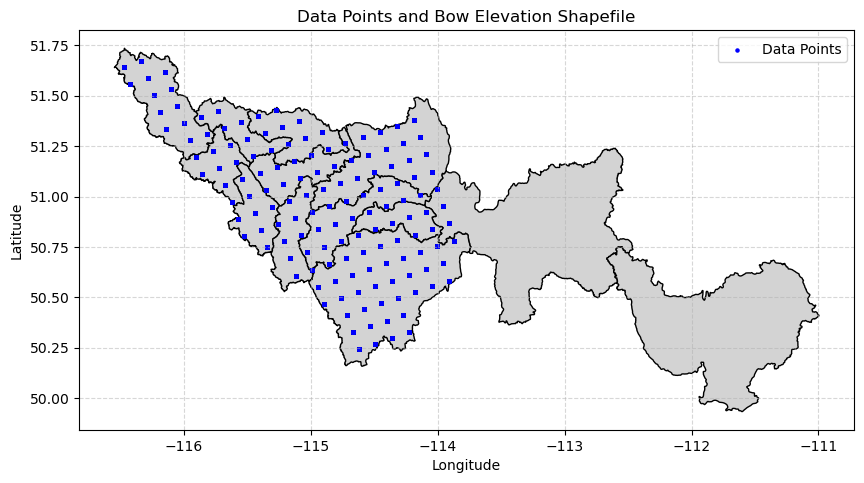

In [78]:
# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_swe_clipped.plot(ax=ax, color='blue', markersize=5, label='Data Points')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Data Points and Bow Elevation Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [8]:
# Read the shapefile using geopandas
#bow_elevation = gpd.read_file(shapefile_path)
# Set CRS if not already set (assume WGS84)
#if bow_elevation.crs is None:
#	bow_elevation.set_crs(epsg=4326, inplace=True)
#print(f"Bow elevation shapefile CRS: {bow_elevation.crs}")  

# List all NetCDF files
file_list = sorted(glob.glob(f"{data_path}CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420*.nc"))

# Prepare an empty list to collect clipped data
clipped_list = []

for nc_file in file_list:
    swe = xr.open_dataset(nc_file)
    dataframe = swe.to_dataframe().reset_index()
    
    # Create GeoDataFrame
    gdf_swe = gpd.GeoDataFrame(
        dataframe,
        geometry=gpd.points_from_xy(dataframe['lon'], dataframe['lat']),
        crs='EPSG:4326'
    )
    # Convert lon from 0-360 to -180 to 180 format
    gdf_swe['lon'] = ((gdf_swe['lon'] + 180) % 360) - 180
    gdf_swe['geometry'] = gpd.points_from_xy(gdf_swe['lon'], gdf_swe['lat'])
    
    # Clip to shapefile
    gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)
    
    # Append to list
    clipped_list.append(gdf_swe_clipped)
    print(f"Processed {nc_file}: {len(gdf_swe_clipped)} points clipped.")

# Concatenate all clipped data
all_clipped = pd.concat(clipped_list, ignore_index=True)

# Save to CSV
output_file = output_path + 'bow_swe_data_rlon246-280_rlat386-420.csv'
all_clipped.to_csv(output_file, index=False)
print(f"Extracted SWE data saved to {output_file}")

# Display a sample
display(all_clipped.head())

Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1980-1983.nc: 175320 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1984-1987.nc: 175320 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1988-1991.nc: 175320 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1992-1995.nc: 175320 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\inp

,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_P_SWE_LAND,geometry
0,1982-12-23 20:00:00,-6.39,-12.44722,-111.887512,50.045334,1,NaN,POINT (-111.88751 50.04533)
1,1982-11-10 22:00:00,-6.39,-12.44722,-111.887512,50.045334,1,NaN,POINT (-111.88751 50.04533)
2,1980-10-07 17:00:00,-6.39,-12.44722,-111.887512,50.045334,1,NaN,POINT (-111.88751 50.04533)
3,1980-07-16 15:00:00,-6.39,-12.44722,-111.887512,50.045334,1,NaN,POINT (-111.88751 50.04533)
4,1980-05-19 01:00:00,-6.39,-12.44722,-111.887512,50.045334,1,NaN,POINT (-111.88751 50.04533)


In [ ]:
# open csv files
bow_swe_data1 = pd.read_csv(output_path + 'bow_swe_data_rlon211-245_rlat421-455.csv')
bow_swe_data2 = pd.read_csv(output_path + 'bow_swe_data_rlon246-280_rlat421-455.csv')
bow_swe_data3 = pd.read_csv(output_path + 'bow_swe_data_rlon246-280_rlat386-420.csv')

# drop rows with NaN CaSR_v3.1_P_SWE_LAND
bow_swe_data1 = bow_swe_data1.dropna(subset=['CaSR_v3.1_P_SWE_LAND'])
bow_swe_data2 = bow_swe_data2.dropna(subset=['CaSR_v3.1_P_SWE_LAND'])
bow_swe_data3 = bow_swe_data3.dropna(subset=['CaSR_v3.1_P_SWE_LAND'])
# concatenate all dataframes
bow_swe_data = pd.concat([bow_swe_data1, bow_swe_data2, bow_swe_data3], ignore_index=True)
# Save the combined data to a CSV file
output_file_combined = output_path + 'bow_swe_data_combined.csv'
bow_swe_data.to_csv(output_file_combined, index=False)  
print(f"Combined SWE data saved to {output_file_combined}")
# Display the combined data
display(bow_swe_data.head())

Combined SWE data saved to C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\casr_data\\bow_swe_data_combined.csv


,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_P_SWE_LAND,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.878418,POINT (-116.13796997070312 51.334590911865234)
1,1982-07-19 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.515625,POINT (-116.13796997070312 51.334590911865234)
2,1983-10-12 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,6.875000,POINT (-116.1875 51.41911315917969)
3,1980-12-11 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,118.125000,POINT (-116.1875 51.41911315917969)
4,1981-07-21 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.000000,POINT (-116.1875 51.41911315917969)


In [5]:
#convert lon from 0-360 to -180 to 180 format
bow_swe_data['lon'] = ((bow_swe_data['lon'] + 180) % 360) - 180


# convert to GeoDataFrame
gdf_bow_swe_data = gpd.GeoDataFrame(
    bow_swe_data,
    geometry=gpd.points_from_xy(bow_swe_data['lon'], bow_swe_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_swe_data.head())

,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_P_SWE_LAND,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.878418,POINT (-116.13797 51.33459)
1,1982-07-19 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.515625,POINT (-116.13797 51.33459)
2,1983-10-12 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,6.875000,POINT (-116.18750 51.41911)
3,1980-12-11 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,118.125000,POINT (-116.18750 51.41911)
4,1981-07-21 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.000000,POINT (-116.18750 51.41911)


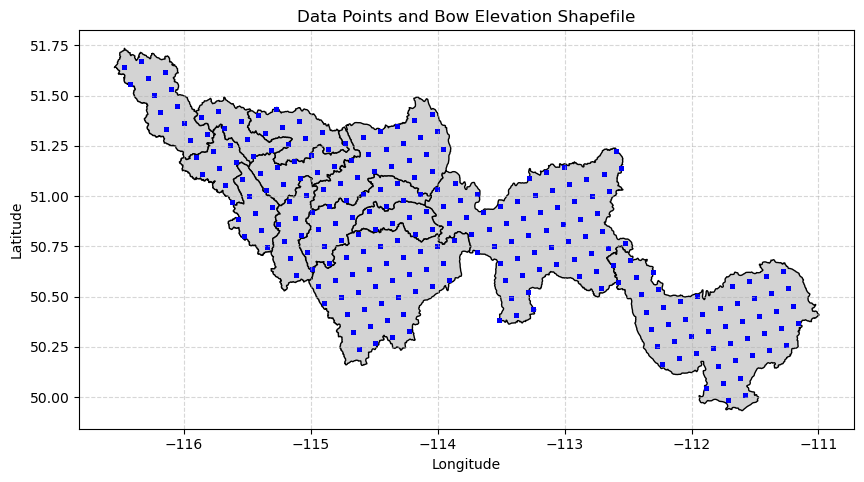

In [6]:
# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_bow_swe_data.plot(ax=ax, color='blue', markersize=5, label='Data Points')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Data Points and Bow Elevation Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# 2. Open all precipitation data files and combine them into a single xarray dataset spatially and temporally


In [10]:
# List all NetCDF files
file_list = sorted(glob.glob(f"{data_path}CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455*.nc"))

# Prepare an empty list to collect clipped data
clipped_list = []

for nc_file in file_list:
    swe = xr.open_dataset(nc_file)
    dataframe = swe.to_dataframe().reset_index()
    
    # Create GeoDataFrame
    gdf_swe = gpd.GeoDataFrame(
        dataframe,
        geometry=gpd.points_from_xy(dataframe['lon'], dataframe['lat']),
        crs='EPSG:4326'
    )
    # Convert lon from 0-360 to -180 to 180 format
    gdf_swe['lon'] = ((gdf_swe['lon'] + 180) % 360) - 180
    gdf_swe['geometry'] = gpd.points_from_xy(gdf_swe['lon'], gdf_swe['lat'])
    
    # Clip to shapefile
    gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)
    
    # Append to list
    clipped_list.append(gdf_swe_clipped)
    print(f"Processed {nc_file}: {len(gdf_swe_clipped)} points clipped.")

# Concatenate all clipped data
all_clipped = pd.concat(clipped_list, ignore_index=True)

# Save to CSV
output_file = output_path + 'bow_precip_data_rlon246-280_rlat421-455.csv'
all_clipped.to_csv(output_file, index=False)
print(f"Extracted SWE data saved to {output_file}")

# Display a sample
display(all_clipped.head())

Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1980-1983.nc: 3751848 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1984-1987.nc: 3751848 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1988-1991.nc: 3751848 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1992-1995.nc: 3751848 points clipped.
Processed C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data

,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_A_PR24_SFC,geometry
0,1981-05-27 17:00:00,-5.76,-13.257217,-113.381409,50.409008,1,NaN,POINT (-113.38141 50.40901)
1,1983-01-17 22:00:00,-5.76,-13.257217,-113.381409,50.409008,1,NaN,POINT (-113.38141 50.40901)
2,1981-04-16 14:00:00,-5.76,-13.257217,-113.381409,50.409008,1,NaN,POINT (-113.38141 50.40901)
3,1981-06-03 07:00:00,-5.76,-13.257217,-113.381409,50.409008,1,NaN,POINT (-113.38141 50.40901)
4,1981-09-24 10:00:00,-5.76,-13.257217,-113.381409,50.409008,1,NaN,POINT (-113.38141 50.40901)


In [7]:
# open csv files
bow_precip_data1 = pd.read_csv(output_path + 'bow_precip_data_rlon211-245_rlat421-455.csv')
bow_precip_data2 = pd.read_csv(output_path + 'bow_precip_data_rlon246-280_rlat421-455.csv')
bow_precip_data3 = pd.read_csv(output_path + 'bow_precip_data_rlon246-280_rlat386-420.csv')

# drop rows with NaN CaSR_v3.1_P_SWE_LAND
bow_precip_data1 = bow_precip_data1.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
bow_precip_data2 = bow_precip_data2.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
bow_precip_data3 = bow_precip_data3.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
# concatenate all dataframes
bow_precip_data = pd.concat([bow_precip_data1, bow_precip_data2, bow_precip_data3], ignore_index=True)
# Save the combined data to a CSV file
output_file_combined = output_path + 'bow_precip_data_combined.csv'
bow_precip_data.to_csv(output_file_combined, index=False)  
print(f"Combined SWE data saved to {output_file_combined}")
# Display the combined data
display(bow_precip_data.head())

Combined SWE data saved to C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\casr_data\\bow_precip_data_combined.csv


,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_A_PR24_SFC,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.000010,POINT (-116.13796997070312 51.334590911865234)
1,1982-07-19 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.002766,POINT (-116.13796997070312 51.334590911865234)
2,1983-10-12 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.000024,POINT (-116.1875 51.41911315917969)
3,1980-12-11 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.004579,POINT (-116.1875 51.41911315917969)
4,1981-07-21 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.005400,POINT (-116.1875 51.41911315917969)


In [8]:

#convert lon from 0-360 to -180 to 180 format
bow_precip_data['lon'] = ((bow_precip_data['lon'] + 180) % 360) - 180

# convert to GeoDataFrame
gdf_bow_precip_data = gpd.GeoDataFrame(
    bow_precip_data,
    geometry=gpd.points_from_xy(bow_precip_data['lon'], bow_precip_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_precip_data.head())

,time,rlat,rlon,lon,lat,rotated_pole,CaSR_v3.1_A_PR24_SFC,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.000010,POINT (-116.13797 51.33459)
1,1982-07-19 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.002766,POINT (-116.13797 51.33459)
2,1983-10-12 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.000024,POINT (-116.18750 51.41911)
3,1980-12-11 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.004579,POINT (-116.18750 51.41911)
4,1981-07-21 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.005400,POINT (-116.18750 51.41911)


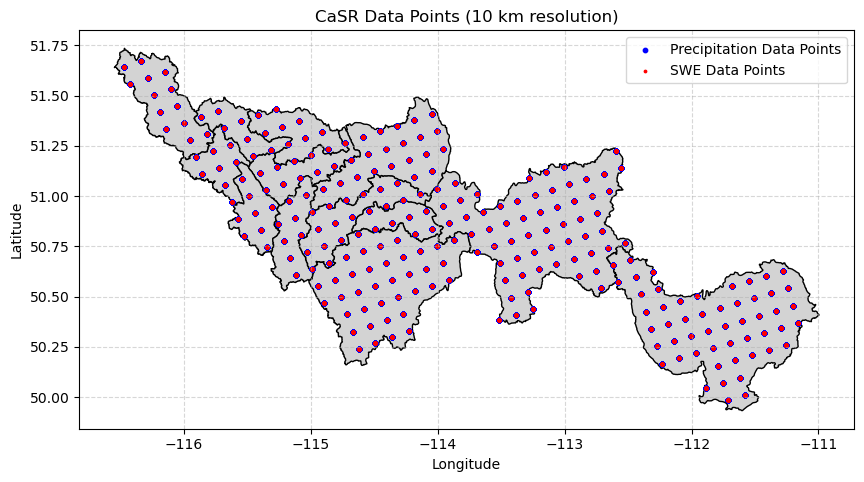

In [11]:
# drop repeated coordinates based on geometry column
gdf_bow_precip_data1 = gdf_bow_precip_data.drop_duplicates(subset="geometry")

gdf_bow_swe_data1 = gdf_bow_swe_data.drop_duplicates(subset="geometry")

# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_bow_precip_data.plot(ax=ax, color='blue', markersize=10, label='Precipitation Data Points')
gdf_bow_swe_data.plot(ax=ax, color='red', markersize=3, label='SWE Data Points')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('CaSR Data Points (10 km resolution)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.savefig(output_path + 'bow_data_points_plot.png', dpi=300)
plt.show()


In [30]:
# Merge SWE and Precipitation data on time, lon, and lat
combined_data = pd.merge(
    bow_swe_data,
    bow_precip_data,
    on=['time', 'lon', 'lat'],
    suffixes=('_swe', '_precip')
)

# Display the first few rows of the combined dataframe
display(combined_data.head())

,time,rlat_swe,rlon_swe,lon,lat,rotated_pole_swe,CaSR_v3.1_P_SWE_LAND,geometry_swe,rlat_precip,rlon_precip,rotated_pole_precip,CaSR_v3.1_A_PR24_SFC,geometry_precip
0,1980-10-10 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.878418,POINT (-116.13796997070312 51.334590911865234),-4.32,-14.607224,1,0.000010,POINT (-116.13796997070312 51.334590911865234)
1,1982-07-19 12:00:00,-4.32,-14.607224,-116.13797,51.334590,1,0.515625,POINT (-116.13796997070312 51.334590911865234),-4.32,-14.607224,1,0.002766,POINT (-116.13796997070312 51.334590911865234)
2,1983-10-12 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,6.875000,POINT (-116.1875 51.41911315917969),-4.23,-14.607224,1,0.000024,POINT (-116.1875 51.41911315917969)
3,1980-12-11 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,118.125000,POINT (-116.1875 51.41911315917969),-4.23,-14.607224,1,0.004579,POINT (-116.1875 51.41911315917969)
4,1981-07-21 12:00:00,-4.23,-14.607224,-116.18750,51.419113,1,0.000000,POINT (-116.1875 51.41911315917969),-4.23,-14.607224,1,0.005400,POINT (-116.1875 51.41911315917969)


In [32]:
# Rename columns to standard names for easier use
combined_data = combined_data.rename(
	columns={
		'CaSR_v3.1_P_SWE_LAND': 'SWE',
		'CaSR_v3.1_A_PR24_SFC': 'Precipitation'
	}
)

#keep only the columns of interest (use the already renamed columns)
combined_data = combined_data[['time', 'lon', 'lat', 'SWE', 'Precipitation']]

#conver back to dataframe
combined_data = pd.DataFrame(combined_data)

# convert precipitation from m to mm
combined_data['Precipitation'] = combined_data['Precipitation'] * 1000  # Convert from meters to millimeters
# Convert SWE from kg/m^2 to mm (assuming density of water is 1000 kg/m^3)

# Convert 'time' column to datetime format
combined_data['time'] = pd.to_datetime(combined_data['time']).dt.date

# add a new column Grid_id with unique values based on lat and lon
# Assign unique integer Grid_id for each unique (lat, lon) pair
unique_coords = combined_data[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
unique_coords['Grid_id'] = range(1, len(unique_coords) + 1)
combined_data = combined_data.merge(unique_coords, on=['lat', 'lon'], how='left')
combined_data['Grid_id'] = combined_data['Grid_id'].astype(int)

# Reorder columns to have 'Grid_id' at the beginning and use new column names
combined_data = combined_data[['Grid_id', 'time', 'lon', 'lat', 'SWE', 'Precipitation']]

# Save the combined data to a CSV file
output_file_combined = output_path + 'bow_combined_data.csv'
combined_data.to_csv(output_file_combined, index=False)
print(f"Combined data saved to {output_file_combined}")
# Display the first few rows of the combined dataframe
display(combined_data)

Combined data saved to C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\casr_data\\bow_combined_data.csv


,Grid_id,time,lon,lat,SWE,Precipitation
0,1,1980-10-10,-116.13797,51.334590,0.878418,0.009879
1,1,1982-07-19,-116.13797,51.334590,0.515625,2.765854
2,2,1983-10-12,-116.18750,51.419113,6.875000,0.023846
3,2,1980-12-11,-116.18750,51.419113,118.125000,4.578907
4,2,1981-07-21,-116.18750,51.419113,0.000000,5.400473
...,...,...,...,...,...,...
4130242,253,2021-06-25,-111.75397,50.070770,0.000000,3.667285
4130243,253,2020-04-17,-111.75397,50.070770,0.902344,0.001052
4130244,253,2023-04-03,-111.75397,50.070770,3.375000,6.179713
4130245,253,2021-12-15,-111.75397,50.070770,1.625000,0.002916
